# Stacked Model
**Models used** <br>
1) MobileNet V2<br>
2) Denesnet 169<br>


# Import the Necessary Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,accuracy_score
from keras.layers import concatenate
from keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import MaxPooling2D, Flatten,Conv2D, Dense,BatchNormalization,GlobalAveragePooling2D,Dropout
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2


# Data Collection


In [3]:
!mkdir "/tmp/X-RAY/"

In [4]:
!mkdir -p tmp/X-RAY/COVID
!mkdir -p tmp/X-RAY/LUNG_OPACITY
!mkdir -p tmp/X-RAY/NORMAL
!mkdir -p tmp/X-RAY/PNEUMONIA

In [5]:
!cp /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/*.png tmp/X-RAY/COVID/
!cp /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/*.png tmp/X-RAY/NORMAL/
!cp /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity/images/*.png tmp/X-RAY/LUNG_OPACITY/
!cp /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral\ Pneumonia/images/*.png tmp/X-RAY/PNEUMONIA/


In [9]:
!ls tmp/X-RAY/

COVID  LUNG_OPACITY  NORMAL  PNEUMONIA


# Data Preprocessing

In [10]:
dataset_dir = "tmp/X-RAY/"

categories = ["COVID", "LUNG_OPACITY", "NORMAL", "PNEUMONIA"]
image_counts = {}

for category in categories:
    category_path = os.path.join(dataset_dir, category)
    image_counts[category] = len(os.listdir(category_path))

print(image_counts)


{'COVID': 3616, 'LUNG_OPACITY': 6012, 'NORMAL': 10192, 'PNEUMONIA': 1345}


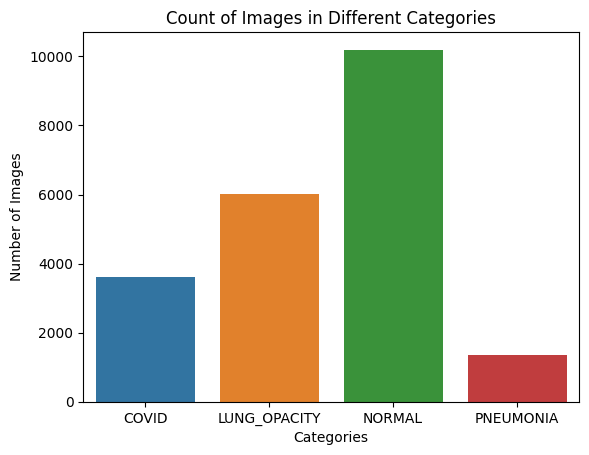

In [11]:
sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()))

plt.xlabel("Categories")
plt.ylabel("Number of Images")
plt.title("Count of Images in Different Categories")
plt.show()

# Data Augmentation

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_path="tmp/X-RAY/"

In [30]:
train_datagen = ImageDataGenerator(rescale=1/255,zoom_range=0.2,shear_range=0.2,validation_split=0.2)

In [31]:
train=train_datagen.flow_from_directory(train_path,target_size=(224,224),batch_size=16,subset='training',class_mode='categorical')# input pixels of images trained for VGGnet
test=train_datagen.flow_from_directory(train_path,target_size=(224,224),batch_size=16,subset='validation',class_mode='categorical')

Found 16933 images belonging to 4 classes.
Found 4232 images belonging to 4 classes.


# Model Definition

In [19]:
input_shape = (224,224,3)
input_layer = Input(shape = (224, 224, 3))
mobilenet_base = MobileNetV2(weights = 'imagenet',input_shape = input_shape,include_top = False)
densenet_base = DenseNet169(weights = 'imagenet', input_shape = input_shape,include_top = False)

9406464/9406464 [==============================] - 1s 0us/step


In [20]:
for layer in mobilenet_base.layers:
    layer.trainable =  False
for layer in densenet_base.layers:
    layer.trainable = False

In [21]:
model_mobilenet = mobilenet_base(input_layer)
model_mobilenet = GlobalAveragePooling2D()(model_mobilenet)
output_mobilenet = Flatten()(model_mobilenet)

In [23]:
model_densenet = densenet_base(input_layer)
model_densenet = GlobalAveragePooling2D()(model_densenet)
output_densenet = Flatten()(model_densenet)

merged = tf.keras.layers.Concatenate()([output_mobilenet, output_densenet])

x = BatchNormalization()(merged)
x = Dense(256,activation = 'relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(128,activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(4, activation = 'softmax')(x)
stacked_model = tf.keras.models.Model(inputs = input_layer, outputs = x)

In [24]:
optm = Adam(lr=0.0001)
stacked_model.compile(loss='categorical_crossentropy', optimizer=optm, 
                  metrics=['accuracy'])
stacked_model.summary()

In [26]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
EarlyStopping = EarlyStopping(monitor='val_accuracy',
                              min_delta=.01,
                              patience=6,
                              verbose=1,
                              mode='auto',
                              baseline=None,
                              restore_best_weights=True)

# Model Training

In [60]:
epochs = 20  
batch_size  = 16
stacked_history = stacked_model.fit(train,
                              steps_per_epoch = 16933 // batch_size,
                              epochs = 20,
                              validation_data = test,
                              callbacks=[EarlyStopping])

Epoch 1/20
1058/1058 [==============================] - 249s 236ms/step - loss: 0.4361 - accuracy: 0.8395 - val_loss: 0.3077 - val_accuracy: 0.8922
Epoch 2/20
1058/1058 [==============================] - 251s 237ms/step - loss: 0.4205 - accuracy: 0.8438 - val_loss: 0.3229 - val_accuracy: 0.8837
Epoch 3/20
1058/1058 [==============================] - 249s 236ms/step - loss: 0.3966 - accuracy: 0.8528 - val_loss: 0.2901 - val_accuracy: 0.8956
Epoch 4/20
1058/1058 [==============================] - 253s 239ms/step - loss: 0.3929 - accuracy: 0.8562 - val_loss: 0.2808 - val_accuracy: 0.9000
Epoch 5/20
1058/1058 [==============================] - 251s 237ms/step - loss: 0.3720 - accuracy: 0.8663 - val_loss: 0.3046 - val_accuracy: 0.8963
Epoch 6/20
1058/1058 [==============================] - 249s 235ms/step - loss: 0.3756 - accuracy: 0.8613 - val_loss: 0.2865 - val_accuracy: 0.8993
Epoch 7/20
1058/1058 [==============================] - 248s 234ms/step - loss: 0.3676 - accuracy: 0.8663 - val_

# Evaluation

In [62]:
test_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.2)  
test_generator = test_datagen.flow_from_directory(
    "tmp/X-RAY/",
    target_size=(224,224),
    batch_size=64,
    class_mode='categorical',  
    shuffle=False,  
    subset='validation'   
)

Found 4232 images belonging to 4 classes.


In [63]:
y_pred = stacked_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print("Accuracy: {:.2f}%".format(accuracy * 100))

67/67 [==============================] - 15s 218ms/step
Accuracy: 90.17%


In [64]:
class_names = ['COVID', 'LUNG_OPACITY','NORMAL', 'PNEUMONIA']
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print(report)

              precision    recall  f1-score   support

       COVID       0.91      0.82      0.86       723
LUNG_OPACITY       0.90      0.88      0.89      1202
      NORMAL       0.89      0.95      0.92      2038
   PNEUMONIA       0.94      0.88      0.91       269

    accuracy                           0.90      4232
   macro avg       0.91      0.88      0.90      4232
weighted avg       0.90      0.90      0.90      4232



# Evaluation Graphs

In [65]:
training_loss = stacked_history.history['loss']
validation_loss = stacked_history.history['val_loss']

training_accuracy = stacked_history.history['accuracy']
validation_accuracy = stacked_history.history['val_accuracy']

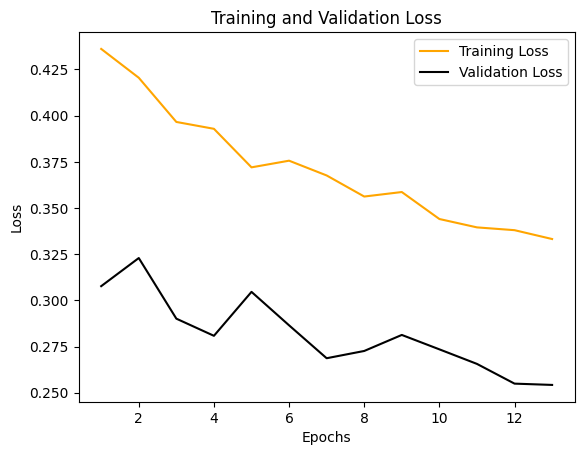

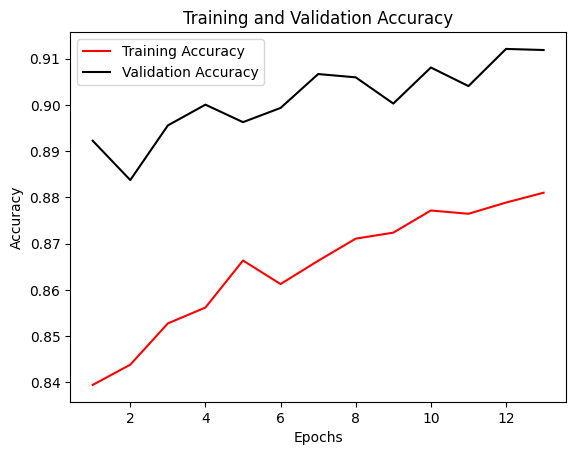

In [66]:
epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, 'orange', label='Training Loss')
plt.plot(epochs, validation_loss, 'k', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, training_accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'k', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [79]:
import pandas as pd
names=["COVID","LUNG_OPACITY","NORMAL","PNEUMONIA"]
confusion_mat=pd.crosstab(y_true, y_pred_classes)
confusion_mat.columns=names
confusion_mat.index=names
confusion_mat

,COVID,LUNG_OPACITY,NORMAL,PNEUMONIA
COVID,595,46,77,5
LUNG_OPACITY,30,1052,120,0
NORMAL,28,68,1931,11
PNEUMONIA,0,0,31,238
